In [245]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 32
input_size = 32
hidden_size = 32
hidden_size_fc = 128
num_layers = 2
num_classes = 10
batch_size = 256
num_epochs = 4
learning_rate = 0.003

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [64]:
root = './'
# CIFAR 10
train_dataset = torchvision.datasets.CIFAR10(root, train=True, transform=transform,download=True)
test_dataset  = torchvision.datasets.CIFAR10(root, train=False, transform=transform)
print(len(train_dataset), len(test_dataset))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

print("Loading is done")

Files already downloaded and verified
50000 10000
Loading is done


In [65]:
# just visualize
print(np.shape(train_dataset[0][0]))

torch.Size([3, 32, 32])


### For start, check the model if it works on colorful images of CIFAR. For that input size of LSTM, reshape must be correctly changed 

In [261]:
# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size*3, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*2)  # 2 for bidirection
        self.fc2 = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out) 
        out = self.fc2(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

BiRNN(
  (lstm): LSTM(96, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [262]:
# Train the model on CIFAR
def train_model(model, train_loader):
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, 3 * input_size).to(device) # [batch_size, 32, 32 * 3]
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % len(train_loader) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print("DONE")

train_model(model, train_loader)

Epoch [1/4], Step [196/196], Loss: 1.6940
Epoch [2/4], Step [196/196], Loss: 1.4843
Epoch [3/4], Step [196/196], Loss: 1.3731
Epoch [4/4], Step [196/196], Loss: 1.3056
DONE


### Test the model prodiving accuracy and confusion matrix

In [263]:
number_classes = 10
classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

Test Accuracy of the model on the 10000 test images: 50.88 %


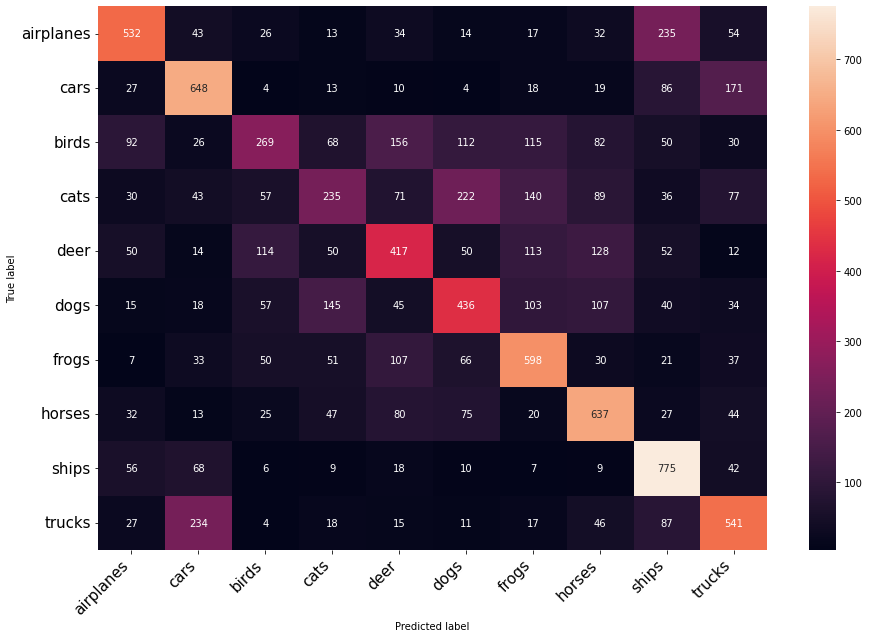

In [253]:
# Test the model
def test_model(model, test_loader):
    confusion_matrix = np.zeros((number_classes, number_classes))
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, 3 * input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

    plt.figure(figsize=(15,10))

    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_model(model, test_loader)
#Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 55.06 %


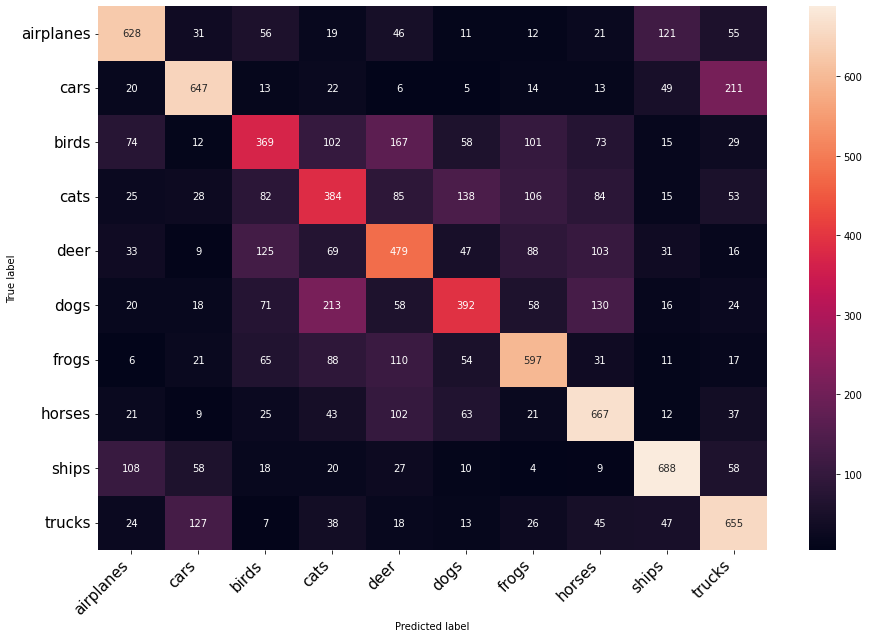

In [102]:
# hidden_size=128

#### with hidden_size=128 for both bi_lstm and fc layers accuracy is about 56% 

### Next, according to the task images must be transformed into sequences of different lengths using Lambda functions in Pytorch. 
### Let's start with `length=5`. Here FiveCrop function is helpful.

In [130]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.FiveCrop(32), # this is a list of PIL Images
    transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])), # returns a 4D tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [131]:
root = './'
# CIFAR 10
train_dataset_crop = torchvision.datasets.CIFAR10(root, train=True, transform=transform, download=True)
test_dataset_crop  = torchvision.datasets.CIFAR10(root, train=False, transform=transform)
print(len(train_dataset_crop), len(test_dataset_crop))

# Data loader
train_loader_crop = torch.utils.data.DataLoader(dataset=train_dataset_crop, batch_size=batch_size, shuffle=True)
test_loader_crop = torch.utils.data.DataLoader(dataset=test_dataset_crop, batch_size=batch_size, shuffle=False)

print("Loading is done")

Files already downloaded and verified
50000 10000
Loading is done


In [105]:
# Just visualize
np.shape(train_dataset_crop[0][0])

torch.Size([5, 3, 32, 32])

### Again, here are changed input size in LSTM and reshape function for data to get form like `[length x batch_size x 3072]`

In [132]:
# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
#         self.hidden_size_bi = hidden_size_bi
#         self.hidden_size_fc = hidden_size_fc
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size**2*3, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)  # 2 for bidirection
        self.fc2 = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc2(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

BiRNN(
  (lstm): LSTM(3072, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### Define train function with changed reshape 

In [133]:
def train_sequenced_data(model, train_loader_crop):
    # Train the model on CIFAR
    total_step = len(train_loader_crop)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader_crop):
            images = images.reshape(len(images), -1, 3 * input_size * sequence_length).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % len(train_loader_crop) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print("DONE")
    
train_sequenced_data(model, train_loader_crop)

Epoch [1/4], Step [196/196], Loss: 1.8645
Epoch [2/4], Step [196/196], Loss: 1.7043
Epoch [3/4], Step [196/196], Loss: 1.6962
Epoch [4/4], Step [196/196], Loss: 1.5090
DONE


### Define test function with changed reshape for sequences

Test Accuracy of the model on the 10000 test images: 40.01 %


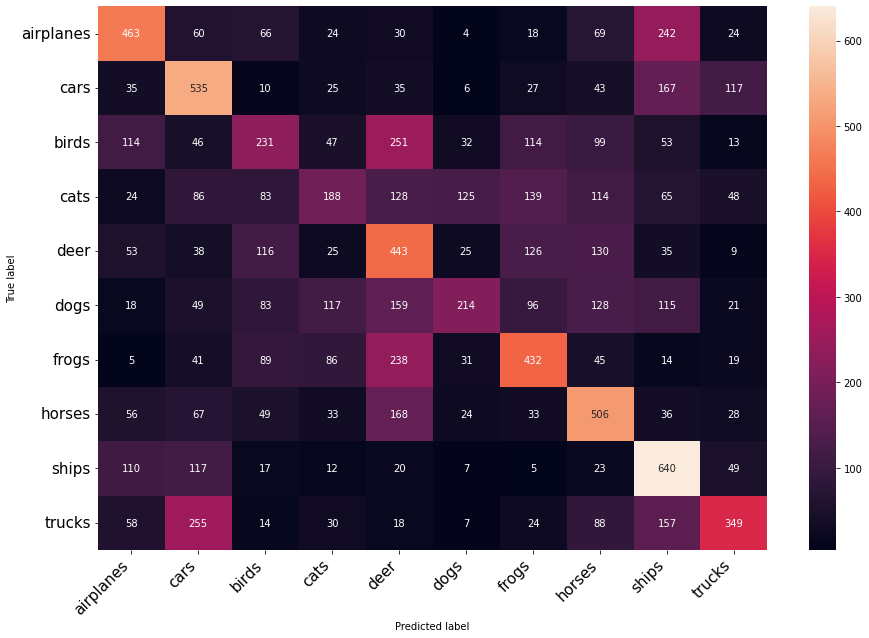

In [109]:
# Test the model
def test_sequenced_data(model, test_loader):
    confusion_matrix = np.zeros((number_classes, number_classes))
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(len(images), -1, 3 * input_size * sequence_length).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

    plt.figure(figsize=(15,10))

    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_sequenced_data(model, test_loader_crop)

### Another experiment with `lenght=10`. Here TenCrop function can be used.

In [116]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.TenCrop(32), # this is a list of PIL Images
    transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])) # returns a 4D tensor
])

In [117]:
root = './'
# CIFAR 10
train_dataset_crop = torchvision.datasets.CIFAR10(root, train=True, transform=transform,download=True)
test_dataset_crop  = torchvision.datasets.CIFAR10(root, train=False, transform=transform)
print(len(train_dataset_crop), len(test_dataset_crop))

# Data loader
train_loader_crop = torch.utils.data.DataLoader(dataset=train_dataset_crop, batch_size=batch_size,shuffle=True)
test_loader_crop = torch.utils.data.DataLoader(dataset=test_dataset_crop, batch_size=batch_size,shuffle=False)

print("Loading is done")

Files already downloaded and verified
50000 10000
Loading is done


In [112]:
# Just visualize
np.shape(test_dataset_crop[0][0])

torch.Size([10, 3, 32, 32])

In [118]:
train_sequenced_data(model, train_loader_crop)

Epoch [1/4], Step [196/196], Loss: 1.8230
Epoch [2/4], Step [196/196], Loss: 1.8002
Epoch [3/4], Step [196/196], Loss: 1.7313
Epoch [4/4], Step [196/196], Loss: 1.5931
DONE


Test Accuracy of the model on the 10000 test images: 40.19 %


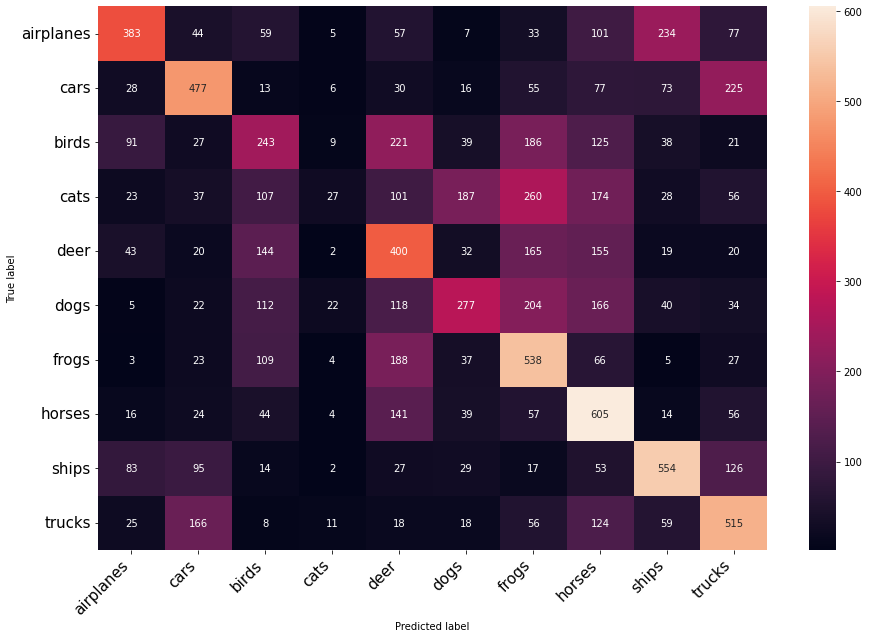

In [119]:
test_sequenced_data(model, test_loader_crop)

### Last experiment with `length=20`

In [200]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.TenCrop(32), # this is a list of PIL Images
        transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])), # returns a 4D tensor
    ])

In [201]:
root = './'
# CIFAR 10
train_dataset_crop = torchvision.datasets.CIFAR10(root, train=True, transform=transform,download=True)
test_dataset_crop  = torchvision.datasets.CIFAR10(root, train=False, transform=transform)
print(len(train_dataset_crop), len(test_dataset_crop))

# Data loader
train_loader_crop = torch.utils.data.DataLoader(dataset=train_dataset_crop, batch_size=batch_size,shuffle=True)
test_loader_crop = torch.utils.data.DataLoader(dataset=test_dataset_crop, batch_size=batch_size,shuffle=False)

print("Loading is done")

Files already downloaded and verified
50000 10000
Loading is done


In [202]:
# Just visualize
np.shape(train_dataset_crop[0][0])

torch.Size([10, 3, 32, 32])

In [222]:
# Test stack images
test_stack = torch.cat((test_dataset_crop[0][0], test_dataset_crop[1][0]), dim=0)
print(np.shape(test_stack))

torch.Size([20, 3, 32, 32])


### Here, the concatenation of the same input will be performed directly in the training and test loops, since Five / TenCrop does not provide an increase in more than 10 images of one input. I tried to use torch.cat for this in transform.Compose and outside after loading the train data but some errors occur

In [220]:
def train_sequenced_data(model, train_loader_crop):
    # Train the model on CIFAR
    total_step = len(train_loader_crop)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader_crop):
            images = torch.cat((images, images),dim=1)        # CONCATENATION TO GET Length=20
            images = images.reshape(len(images), -1, 3 * input_size * sequence_length).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % len(train_loader_crop) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print("DONE")
    
train_sequenced_data(model, train_loader_crop)

Epoch [1/4], Step [196/196], Loss: 1.5795
Epoch [2/4], Step [196/196], Loss: 1.7809
Epoch [3/4], Step [196/196], Loss: 1.7087
Epoch [4/4], Step [196/196], Loss: 1.6823
DONE


Test Accuracy of the model on the 10000 test images: 40.72 %


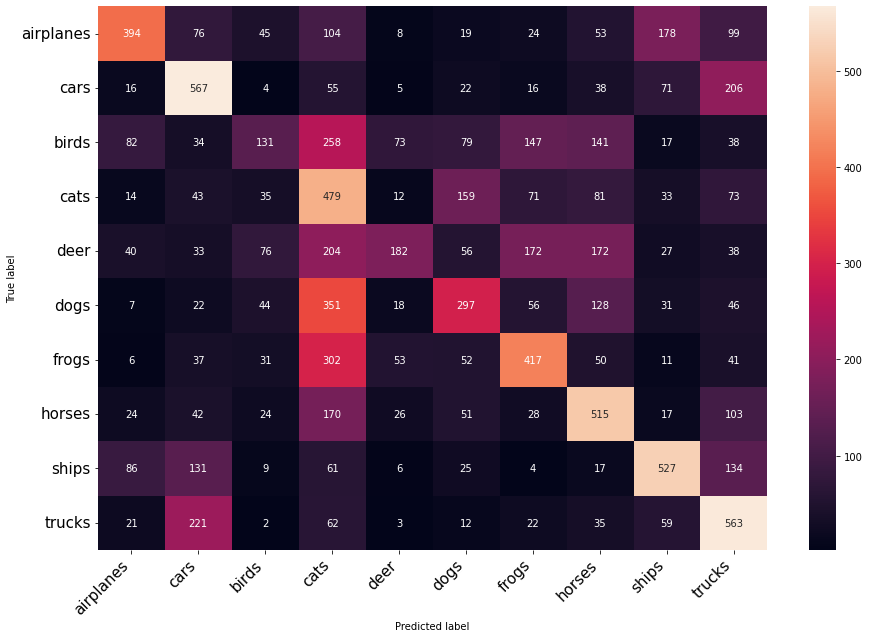

In [221]:
# Test the model
def test_sequenced_data(model, test_loader):
    confusion_matrix = np.zeros((number_classes, number_classes))
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = torch.cat((images, images),dim=1)        # CONCATENATION TO GET Length=20
            images = images.reshape(len(images), -1, 3 * input_size * sequence_length).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

    plt.figure(figsize=(15,10))

    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_sequenced_data(model, test_loader_crop)